In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
from wfdb import processing
import pandas as pd
from IPython.display import Math, Latex
from IPython.core.display import Image
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline   
from datetime import datetime
from datetime import timedelta
from keras.utils import to_categorical

# extracts physical ECG signals from participant data files and constructs a dataframe of ECG signals from all 
# participants plus additional columns to label age and participant number


def create_giant_dataframe():
    ages = []
    participants = []
    # parses through all data file names
    for i in ['y','o']:
        file = list('data/f1y01')
        file = list(file)
        file[7] = i
        file = ''.join(file)
        for j in range(1,3):
            file = list(file)
            file[6] = str(j)
            file = ''.join(file)
            for k in range(1,11):
                if k == 1:
                    file = list(file)
                    file[8:] = str('01')
                    file = ''.join(file)
                if k < 10:
                    file = list(file)
                    file[9] = str(k)
                    file = ''.join(file)
                else:
                    file = list(file)
                    file[8:] = str(k)
                    file = ''.join(file)
                    
                if file == 'data/f2o05': # outlier data
                    continue
                
                # creates record object from participant data file
                record = wfdb.rdrecord(file, channels=[1])
                # extracts array of physical ECG signals from record object
                record.p_signal = np.nan_to_num(record.p_signal)
                
                if i == 'y':
                    ages_temp = ['Young']*len(record.p_signal)
                    ages.extend(ages_temp)
                else: # i == 'o':
                    ages_temp = ['Old']*len(record.p_signal)
                    ages.extend(ages_temp)
                    
                if j == 1:
                    participants_temp = ['P' + str(k)]*len(record.p_signal)
                    participants.extend(participants_temp)
                else: # j == 2:
                    participants_temp = ['P' + str(k+10)]*len(record.p_signal)
                    participants.extend(participants_temp)
                
                
                if file == 'data/f1y01':
                    df = pd.DataFrame(record.p_signal, columns=['p_signal'])
                else:
                    df_temp = pd.DataFrame(record.p_signal, columns=['p_signal'])
                    df = df.append(df_temp)
    
    # adds additional columns to label age and participant number of each participant
    df['Age'] = ages
    df['Participant'] = participants
    return df

df = create_giant_dataframe()
display(df)

,p_signal,Age,Participant
0,7.952000,Young,P1
1,7.936000,Young,P1
2,8.004000,Young,P1
3,8.064000,Young,P1
4,7.980000,Young,P1
...,...,...,...
1693417,-0.041504,Old,P20
1693418,-0.039062,Old,P20
1693419,-0.043945,Old,P20
1693420,-0.029297,Old,P20


In [7]:
# generates windowed dataframe of extracted features
def generate_feature_df_with_window(df, ages, participants, window_size, stride):
    w_df = pd.DataFrame()
    grouped_df = df.groupby(['Age', 'Participant'])
    for age in ages:
        for participant in participants:
            # excludes P15 due to outlier data
            if age == 'Old' and participant == 'P15':
                continue
            else:
                p_df = grouped_df.get_group((age, participant))
                dfs = sliding_window(p_df, window_size=window_size, stride=stride)
                for windowed_df in dfs:
                    if len(windowed_df) == 0:
                        continue
                    feats = extract_all_features(windowed_df, age, participant)
                    w_df = w_df.append(feats, ignore_index=True)
    return w_df

# generates each individual sliding window
def sliding_window(df, window_size, stride, fs = 250):
    dfs = []
    df_cop = df.copy()
    starting_index = df_cop.index[0]
    ending_index = int(df_cop.index[0] + fs*window_size)
    while ending_index <= df_cop.index[-1]:
        windowed_df = df_cop.loc[(df_cop.index >= starting_index) & (df_cop.index <= ending_index)] 
        dfs.append(windowed_df)
        starting_index = int(starting_index + fs*stride)
        ending_index = int(ending_index + fs*stride)
    return dfs

# compiles computed features for each sliding window
def extract_all_features(df, age='none', participant='none', fs = 250):
    feature_dict= {}
    qrs_inds = processing.xqrs_detect(sig=df['p_signal'].values, fs=fs)
    corrected_peak_inds = processing.correct_peaks(sig=df['p_signal'].values, peak_inds=qrs_inds, search_radius=20, smooth_window_size=100) # smoothing window size is one of the varieties of discrete lowpass filters
    hr = processing.compute_hr(sig_len=len(df['p_signal'].values), qrs_inds=sorted(corrected_peak_inds), fs=fs)
    rr = processing.calc_rr(sorted(corrected_peak_inds), fs=fs)
    hr_feats = extract_time_features(hr, prefix='hr')
    rr_feats = extract_time_features(rr, prefix='rr')
    all_feats = {**hr_feats, **rr_feats}
    all_feats['Age'] = age
    all_feats['Participant'] = participant
    return pd.DataFrame(all_feats, index=[0])

# computes features
def extract_time_features(raw_array, prefix=''):
    if type(raw_array) is list:
        raw_array = np.array(raw_array)
    feature_dict= {}
    feature_dict[prefix + '_mean'] = np.nanmean(raw_array)
    feature_dict[prefix + '_std']  = np.nanstd(raw_array)
    feature_dict[prefix + '_rms']  = np.sqrt(np.nanmean(raw_array**2))
    feature_dict[prefix + '_mms']  = ((np.nanmax(raw_array) - np.nanmin(raw_array))/2)
    return feature_dict

ages_list = ['Young','Old']
participants_list = ['P' + str(i) for i in range(1, 21)]
w_df = generate_feature_df_with_window(df, ages=ages_list, participants=participants_list, window_size=1000, stride=500)
display(w_df)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

,hr_mean,hr_std,hr_rms,hr_mms,rr_mean,rr_std,rr_rms,rr_mms,Age,Participant
0,77.794495,6.381002,78.055748,23.448772,193.566228,16.879100,194.300768,71.5,Young,P1
1,77.173874,5.947497,77.402695,22.518177,194.946136,15.889678,195.592632,70.0,Young,P1
2,74.839676,6.701762,75.139145,22.391993,201.334677,19.048709,202.233790,68.0,Young,P1
3,72.336052,6.784934,72.653549,24.492018,208.451209,20.262598,209.433712,81.0,Young,P1
4,71.947021,5.957207,72.193230,22.427362,209.362416,18.013172,210.135898,77.5,Young,P1
...,...,...,...,...,...,...,...,...,...,...
503,72.760345,5.245121,72.949158,64.694771,206.466942,10.717915,206.744944,84.5,Old,P20
504,74.091591,5.945535,74.329765,46.784897,203.125203,11.955905,203.476760,86.0,Old,P20
505,75.702736,12.619240,76.747284,240.384613,199.468850,14.107862,199.967132,122.5,Old,P20
506,75.916023,12.065890,76.868904,239.340042,198.596979,12.627621,198.998033,117.5,Old,P20


In [8]:
print('Number of Young Participant Samples:', len(w_df.groupby('Age').get_group('Young')))
print('Number of Old Participant Samples:', len(w_df.groupby('Age').get_group('Old')))
print('Estimate of Number of Samples per Participant:', len(w_df.groupby(['Age', 'Participant']).get_group(('Young', 'P1'))))

Number of Young Participant Samples: 264
Number of Old Participant Samples: 244
Estimate of Number of Samples per Participant: 13


In [9]:
# Our classification is binary, but we have strings as are classes, so we need to fix it
w_df['Class'] = w_df['Age'] == 'Young'

In [10]:
# SVM
from sklearn.model_selection import train_test_split

X = w_df[[col for col in w_df.columns if col not in ['Age', 'Participant', 'Class']]]
y = w_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #90/10 train/test split
display(X_train,y_train)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

,hr_mean,hr_std,hr_rms,hr_mms,rr_mean,rr_std,rr_rms,rr_mms
491,52.443596,7.429503,52.967232,88.715340,287.457998,22.477036,288.335426,168.5
211,55.911964,3.773326,56.039143,13.274973,268.439785,17.548370,269.012757,55.5
104,69.612404,4.971306,69.789688,15.233696,215.670121,15.132631,216.200364,45.5
33,63.353344,3.959588,63.476959,11.548443,236.916588,14.847045,237.381348,44.5
78,53.024380,7.267338,53.520081,20.932541,284.054608,37.158967,286.474796,105.5
...,...,...,...,...,...,...,...,...
106,70.442604,7.361889,70.826263,16.829390,213.151024,21.585932,214.241246,47.0
270,59.258026,3.979204,59.391468,48.214287,253.308316,14.031342,253.696633,90.0
348,58.935402,7.363357,59.393604,47.892719,256.674203,17.672239,257.281859,120.0
435,57.648827,2.363951,57.697281,7.807926,260.310740,10.442424,260.520106,32.0


array([False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
       False,  True,  True, False,  True, False,  True,  True, False,
        True, False,  True, False, False, False,  True, False, False,
        True,  True, False, False, False,  True, False,  True, False,
       False, False,  True, False,  True, False, False,  True, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False,  True, False, False,  True, False, False,  True,
       False, False, False, False,  True,  True,  True,  True, False,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False, False,  True,  True,  True,
       False,  True, False, False,  True, False, False,  True,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
        True,  True,

In [11]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

acc_test = accuracy_score(clf.predict(X_test), y_test)*100
acc_train = accuracy_score(clf.predict(X_train), y_train)*100
print('Testing Accuracy of 90/10 Split for RBF SVM: %0.4f' % acc_test)
print('Training Accuracy of 90/10 Split for RBF SVM: %0.4f' % acc_train)

Testing Accuracy of 90/10 Split for RBF SVM: 60.7843
Training Accuracy of 90/10 Split for RBF SVM: 52.7352


In [12]:
clf = svm.SVC(kernel='poly') # initialize classifier with RBF decision boundary ### Using SVM method
clf.fit(X_train, y_train) # fit classifier to data

acc_test = accuracy_score(clf.predict(X_test), y_test)*100
acc_train = accuracy_score(clf.predict(X_train), y_train)*100
print('Testing Accuracy of 90/10 Split for Polynomial SVM: %0.4f' % acc_test)
print('Training Accuracy of 90/10 Split for Polynomial SVM: %0.4f' % acc_train)

Testing Accuracy of 90/10 Split for Polynomial SVM: 52.9412
Training Accuracy of 90/10 Split for Polynomial SVM: 51.8600


In [13]:
clf = svm.SVC(kernel='linear') # initialize classifier with RBF decision boundary ### Using SVM method
clf.fit(X_train, y_train) # fit classifier to data

acc_test = accuracy_score(clf.predict(X_test), y_test)*100
acc_train = accuracy_score(clf.predict(X_train), y_train)*100
print('Testing Accuracy of 90/10 Split for Linear SVM: %0.4f' % acc_test)
print('Training Accuracy of 90/10 Split for Linear SVM: %0.4f' % acc_train)

Testing Accuracy of 90/10 Split for Linear SVM: 90.1961
Training Accuracy of 90/10 Split for Linear SVM: 88.6214


In [14]:
# Save SVM model

import pickle
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
filename = 'final_model.sav'
pickle.dump(clf, open(filename, 'wb'))
display(X_train.shape, y_train.shape)
display(X_test.shape, y_train.shape)

(457, 8)

(457,)

(51, 8)

(457,)

In [15]:
clf = svm.SVC(kernel='sigmoid') # initialize classifier with RBF decision boundary ### Using SVM method
clf.fit(X_train, y_train) # fit classifier to data

acc_test = accuracy_score(clf.predict(X_test), y_test)*100
acc_train = accuracy_score(clf.predict(X_train), y_train)*100
print('Testing Accuracy of 90/10 Split for Sigmoid SVM: %0.4f' % acc_test)
print('Training Accuracy of 90/10 Split for Sigmoid SVM: %0.4f' % acc_train)

Testing Accuracy of 90/10 Split for Sigmoid SVM: 52.9412
Training Accuracy of 90/10 Split for Sigmoid SVM: 52.2976


In [16]:
# Discriminant Analysis

def sample_mean(X):
    Xsize = X.shape # returns [num of rows, num of columns] in X
    Xmean = np.array([float(0)]*Xsize[1]) # initialize sample mean matrix
    for j in range(0,Xsize[1]): # for each column in X
        meantemp = 0
        for i in range(0,Xsize[0]): # for each row in X
            meantemp += X[i,j]
        Xtemp = meantemp/Xsize[0]
        Xmean[j] = Xtemp
    return Xmean

def covariance_matrix(X):
    Xsize = X.shape # returns [num of rows, num of columns] in X
    Xmean = sample_mean(X)
    s = np.array([[float(0)]*Xsize[1]]*Xsize[1]) # initialize covariance matrix being symmetric based on num of columns
    for i in range(0,Xsize[1]): # we parse through the initalized symmetric matrix
        for j in range(0,Xsize[1]):
            ssum = 0
            # for each index location in initalized symmetric matrix, we apply our covariance summation equation
            for k in range(0,Xsize[0]): # for each row in X
                ssum += (X[k,i] - Xmean[i])*(X[k,j] - Xmean[j]) 
            stemp = ssum/Xsize[0] # sum divided by number of rows in X
            s[i,j] = stemp
    return s

In [17]:
# 90/10 split

young_w_df_9010 = pd.DataFrame()
w_df_cop = w_df.copy()
participants_young = ['P' + str(i) for i in range(1,19)] # 90% of participants = 18 participants
young_w_df = w_df_cop.groupby('Age').get_group('Young')                    
grouped_df = young_w_df.groupby('Participant')
for participant in participants_young:
    p_df = grouped_df.get_group(participant)
    young_w_df_9010 = young_w_df_9010.append(p_df)
young_w_df_9010 = young_w_df_9010.drop(['Age', 'Participant', 'Class'], axis=1)
display(young_w_df_9010)
young_matrix = young_w_df_9010.values

old_w_df_9010 = pd.DataFrame()
w_df_cop = w_df.copy()
participants_old = ['P' + str(i) for i in range(1,19)] # 90% of participants ~= 17 participants (does not include 'P15')
old_w_df = w_df_cop.groupby('Age').get_group('Old')
grouped_df = old_w_df.groupby('Participant')
for participant in participants_old:
    if participant == 'P15':
        continue
    else:
        p_df = grouped_df.get_group(participant)
        old_w_df_9010 = old_w_df_9010.append(p_df)
old_w_df_9010 = old_w_df_9010.drop(['Age', 'Participant', 'Class'], axis=1)
display(old_w_df_9010)
old_matrix = old_w_df_9010.values

,hr_mean,hr_std,hr_rms,hr_mms,rr_mean,rr_std,rr_rms,rr_mms
0,77.794495,6.381002,78.055748,23.448772,193.566228,16.879100,194.300768,71.5
1,77.173874,5.947497,77.402695,22.518177,194.946136,15.889678,195.592632,70.0
2,74.839676,6.701762,75.139145,22.391993,201.334677,19.048709,202.233790,68.0
3,72.336052,6.784934,72.653549,24.492018,208.451209,20.262598,209.433712,81.0
4,71.947021,5.957207,72.193230,22.427362,209.362416,18.013172,210.135898,77.5
...,...,...,...,...,...,...,...,...
233,60.851559,8.134852,61.392899,31.817772,248.491542,32.246642,250.575124,141.5
234,62.838863,8.208446,63.372719,45.623817,240.616570,29.492845,242.417330,156.0
235,62.769253,6.388318,63.093513,44.597694,240.572254,22.427277,241.615381,144.0
236,61.871010,5.293412,62.097034,23.925241,243.480976,20.501990,244.342622,85.0


,hr_mean,hr_std,hr_rms,hr_mms,rr_mean,rr_std,rr_rms,rr_mms
264,61.246777,2.105592,61.282967,6.688232,244.919608,8.325569,245.061073,25.5
265,60.612934,1.967950,60.644871,7.310190,247.501984,7.920738,247.628694,28.5
266,59.263271,2.088201,59.300045,7.327860,253.132860,8.831163,253.286862,29.5
267,58.869976,2.697203,58.931744,10.612631,254.827551,11.112590,255.069736,39.0
268,59.522228,3.323917,59.614964,10.806723,252.033300,13.615593,252.400809,40.0
...,...,...,...,...,...,...,...,...
478,70.243294,28.019382,75.625443,102.630333,235.619811,64.047902,244.169673,173.5
479,66.146049,23.417953,70.169090,62.307755,246.875494,53.744825,252.657903,158.0
480,63.526375,19.733652,66.520798,52.274117,253.343813,43.998530,257.136070,137.0
481,64.550270,20.242561,67.649818,43.925812,250.389780,44.773706,254.361409,132.0


In [18]:
class mv_discriminant:
    
    def __init__(self, data, prior = 0.5):
        self.m = sample_mean(data)
        self.covmatr = covariance_matrix(data)
        self.pi = np.pi
        self.prior = prior
        
        
    def calc_discriminant(self, x):
        xS = np.dot(x.T, np.linalg.inv(self.covmatr))
        xSx = np.dot(xS, x)
        xSm = np.dot(xS, self.m)
        mS = np.dot(self.m.T, np.linalg.inv(self.covmatr))
        mSm = np.dot(mS, self.m)
        return -.5*np.log(np.linalg.det(self.covmatr)) - .5*(xSx - 2*xSm + mSm) + np.log(self.prior)  

In [19]:
young_disc = mv_discriminant(young_matrix, prior=238/457)
old_disc  = mv_discriminant(old_matrix, prior=219/457)

In [20]:
class discriminant_classifier:
    
    def __init__(self, *discriminants):
        self.classes = discriminants
    
    def classify(self, x):
        return np.argmax([self.classes[i].calc_discriminant(x[0:-1]) for i in range(0, len(self.classes))])
    
    def plot_decision_boundaries(self, x_values):
        classes = [self.classify(i) for i in x_values]
        plt.plot(x_values, classes)
        
    def data_frame_classification(self, df):
        df['Predicted'] = df.apply(self.classify, axis=1)
        return df
          
    def calc_accuracy(self, df, true_col = 'Label', predicted_col = 'Predicted'):
        return 100*sum(df[true_col] == df[predicted_col]) / len(df)

In [21]:
hr_classifier = discriminant_classifier(young_disc, old_disc)

# Compute testing accuracy
participants = ['P' + str(i) for i in range(19,21)] # 10% of participants ~= 2 participants from each age (4 total)
ages = ['Young','Old']
w_df_9010_test = pd.DataFrame()
w_df_cop = w_df.copy()
grouped_df = w_df_cop.groupby(['Age','Participant'])  
for age in ages:
    for participant in participants:
        p_df = grouped_df.get_group((age,participant))
        w_df_9010_test = w_df_9010_test.append(p_df)
data_df = w_df_9010_test.drop(['Age', 'Participant', 'Class'], axis=1)

young_length = len(w_df_9010_test.groupby('Age').get_group('Young'))
old_length = len(w_df_9010_test.groupby('Age').get_group('Old'))

data_df['Label'] = np.append(np.repeat(0, young_length), np.repeat(1, old_length))

data_df = hr_classifier.data_frame_classification(df=data_df)
#display(data_df)

accuracy = hr_classifier.calc_accuracy(data_df)
print('Testing Accuracy of 90/10 Split for Discriminant Analysis: %0.4f' % accuracy)

# Compute training accuracy
participants = ['P' + str(i) for i in range(1,19)] # 10% of participants ~= 2 participants from each age (4 total)
ages = ['Young','Old']
w_df_9010_train = pd.DataFrame()
w_df_cop = w_df.copy()
grouped_df = w_df_cop.groupby(['Age','Participant'])  
for age in ages:
    for participant in participants:
        if age == "Old" and participant == 'P15':
            continue
        else:
            p_df = grouped_df.get_group((age,participant))
            w_df_9010_train = w_df_9010_train.append(p_df)
data_df = w_df_9010_train.drop(['Age', 'Participant', 'Class'], axis=1)

young_length = len(w_df_9010_train.groupby('Age').get_group('Young'))
old_length = len(w_df_9010_train.groupby('Age').get_group('Old'))

data_df['Label'] = np.append(np.repeat(0, young_length), np.repeat(1, old_length))

data_df = hr_classifier.data_frame_classification(df=data_df)
#display(data_df)

accuracy = hr_classifier.calc_accuracy(data_df)
print('Training Accuracy of 90/10 Split for Discriminant Analysis: %0.4f' % accuracy)

Testing Accuracy of 90/10 Split for Discriminant Analysis: 49.0196
Training Accuracy of 90/10 Split for Discriminant Analysis: 82.4945


In [254]:
### Robustness Tests ###

In [255]:
# Switching order of columns for SVM, NaNs did not impact this change in accuracy as there were no NaNs in the dataframe

X = w_df[[col for col in w_df.columns if col not in ['Age', 'Participant', 'Class']]]
y = w_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #90/10 train/test split

testing_accuracies = []
for i in range(0, 8): # number of times columns are rotated
    cols = X_test.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X_test = X_test[cols]
    
    clf = svm.SVC(kernel='linear') # initialize classifier with RBF decision boundary
    clf.fit(X_train, y_train) # fit classifier to data
    
    testing_accuracies.append(accuracy_score(clf.predict(X_test), y_test))
    
accuracy = np.mean(testing_accuracies)*100
print('Mean Testing Accuracy of 90/10 Split for Linear SVM from Rotating Columns: %0.4f' % accuracy)

Mean Testing Accuracy of 90/10 Split for Linear SVM from Rotating Columns: 52.4510


In [256]:
# Switching order of columns for Discrimant Analysis, NaNs did not impact this change in accuracy as there were no NaNs in the dataframe

participants = ['P' + str(i) for i in range(19,21)] # 10% of participants ~= 2 participants from each age (4 total)
ages = ['Young','Old']
w_df_9010_test = pd.DataFrame()
w_df_cop = w_df.copy()
grouped_df = w_df_cop.groupby(['Age','Participant'])  
for age in ages:
    for participant in participants:
        p_df = grouped_df.get_group((age,participant))
        w_df_9010_test = w_df_9010_test.append(p_df)
data_df = w_df_9010_test.drop(['Age', 'Participant', 'Class'], axis=1)

young_length = len(w_df_9010_test.groupby('Age').get_group('Young'))
old_length = len(w_df_9010_test.groupby('Age').get_group('Old'))

data_df['Label'] = np.append(np.repeat(0, young_length), np.repeat(1, old_length)) ###Fix this so the Label isn't rotating

testing_accuracies = []
for i in range(0,8): # number of times columns are rotated
    
    if i > 0:
        data_df = data_df.drop('Predicted', axis=1)
    cols = data_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data_df = data_df[cols]

    data_df = hr_classifier.data_frame_classification(df=data_df)
    accuracy = hr_classifier.calc_accuracy(data_df)
    testing_accuracies.append(accuracy)

print('Mean Testing Accuracy of 90/10 Split for Discriminant Analysis from Rotating Columns: %0.4f' % np.mean(testing_accuracies))

Mean Testing Accuracy of 90/10 Split for Discriminant Analysis from Rotating Columns: 49.7549


In [257]:
# Inserting NaNs for SVM

X = w_df[[col for col in w_df.columns if col not in ['Age', 'Participant', 'Class']]]
y = w_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #90/10 train/test split

revised_columns = X_test.columns[0:8]

for col in revised_columns: # randomly inserts NaNs into DataFrame
    X_test.loc[X_test.sample(frac=0.1).index, col] = pd.np.nan

X_test = np.nan_to_num(X_test)

clf = svm.SVC(kernel='linear') # initialize classifier with RBF decision boundary
clf.fit(X_train, y_train) # fit classifier to data

acc_test = accuracy_score(clf.predict(X_test), y_test)*100
print('Testing Accuracy of 90/10 Split for RBF SVM when Inserting NaNs: %0.4f' % acc_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Testing Accuracy of 90/10 Split for RBF SVM when Inserting NaNs: 70.5882


In [258]:
# Inserting NaNs for Discriminant Analysis

participants = ['P' + str(i) for i in range(19,21)] # 10% of participants ~= 2 participants from each age (4 total)
ages = ['Young','Old']
w_df_9010_test = pd.DataFrame()
w_df_cop = w_df.copy()
grouped_df = w_df_cop.groupby(['Age','Participant'])  
for age in ages:
    for participant in participants:
        p_df = grouped_df.get_group((age,participant))
        w_df_9010_test = w_df_9010_test.append(p_df)
data_df = w_df_9010_test.drop(['Age', 'Participant', 'Class'], axis=1)

young_length = len(w_df_9010_test.groupby('Age').get_group('Young'))
old_length = len(w_df_9010_test.groupby('Age').get_group('Old'))

for col in data_df.columns: # randomly inserts NaNs into DataFrame
    data_df.loc[data_df.sample(frac=0.1).index, col] = pd.np.nan
    
data_df = np.nan_to_num(data_df)
data_df = pd.DataFrame(data_df, columns = ['hr_mean', 'hr_std', 'hr_rms', 'hr_mms', 'rr_mean', 'rr_std', 'rr_rms', 'rr_mms'])

data_df['Label'] = np.append(np.repeat(0, young_length), np.repeat(1, old_length))

data_df = hr_classifier.data_frame_classification(df=data_df)
accuracy = hr_classifier.calc_accuracy(data_df)
print('Training Accuracy of 90/10 Split for Discriminant Analysis when Inserting NaNs: %0.4f' % accuracy)

Training Accuracy of 90/10 Split for Discriminant Analysis when Inserting NaNs: 52.9412


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.1: 90.1961
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.2: 90.1961
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.3: 92.1569
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.4: 88.2353
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.5: 84.3137
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.6: 82.3529
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.7: 80.3922
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.8: 62.7451
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 0.9: 82.3529
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 1.0: 74.5098
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 2.0: 62.7451
Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of 3.0: 56.8627
Testing Accuracy of 90/10 Split for Line

Text(0.5, 0, 'Noise Level')

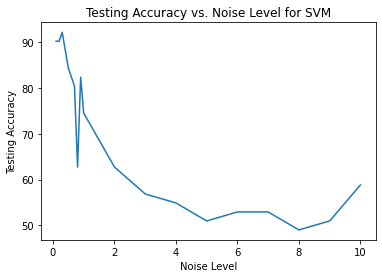

In [259]:
# Adding Noise for SVM

X = w_df[[col for col in w_df.columns if col not in ['Age', 'Participant', 'Class']]]
y = w_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #90/10 train/test split

accuracies = []
for noise_level in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    noise = np.random.normal(0, noise_level, X_test.shape)
    noisy_x = X_test + noise

    clf = svm.SVC(kernel='linear') # initialize classifier with RBF decision boundary ### Using SVM method
    clf.fit(X_train, y_train) # fit classifier to data

    acc_test = accuracy_score(clf.predict(noisy_x), y_test)*100
    accuracies.append(acc_test)
    print('Testing Accuracy of 90/10 Split for Linear SVM with Noise Level of %0.1f: %0.4f' % (noise_level, acc_test))

noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.title('Testing Accuracy vs. Noise Level for SVM')
plt.plot(noises, accuracies)
plt.ylabel('Testing Accuracy')
plt.xlabel('Noise Level')

Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.1: 41.1765
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.2: 45.0980
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.3: 47.0588
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.4: 50.9804
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.5: 47.0588
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.6: 49.0196
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.7: 49.0196
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.8: 49.0196
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 0.9: 47.0588
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 1.0: 49.0196
Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of 2.0: 49.0196

Text(0.5, 0, 'Noise Level')

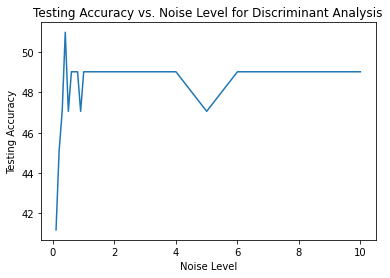

In [260]:
# Adding Noise for Discriminant Analysis

participants = ['P' + str(i) for i in range(19,21)] # 10% of participants ~= 2 participants from each age (4 total)
ages = ['Young','Old']
w_df_9010_test = pd.DataFrame()
w_df_cop = w_df.copy()
grouped_df = w_df_cop.groupby(['Age','Participant'])  
for age in ages:
    for participant in participants:
        p_df = grouped_df.get_group((age,participant))
        w_df_9010_test = w_df_9010_test.append(p_df)
data_df = w_df_9010_test.drop(['Age', 'Participant', 'Class'], axis=1)

young_length = len(w_df_9010_test.groupby('Age').get_group('Young'))
old_length = len(w_df_9010_test.groupby('Age').get_group('Old'))

accuracies = []
for noise_level in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        
    noise = np.random.normal(0, noise_level, data_df.shape)
    noisy_x = data_df + noise

    noisy_x['Label'] = np.append(np.repeat(0, young_length), np.repeat(1, old_length))

    noisy_x = hr_classifier.data_frame_classification(df=noisy_x)
    
    accuracy = hr_classifier.calc_accuracy(noisy_x)
    accuracies.append(accuracy)
    print('Testing Accuracy of 90/10 Split for Discriminant Analysis with Noise Level of %0.1f: %0.4f' % (noise_level, accuracy))

noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.title('Testing Accuracy vs. Noise Level for Discriminant Analysis')
plt.plot(noises, accuracies)
plt.ylabel('Testing Accuracy')
plt.xlabel('Noise Level')